# SoongsilBERT -base model을 사용하여 학습했습니다.

- github 주소: https://github.com/jason9693/Soongsil-BERT
- SoongsilBERT 는 small, base(large) 모델 2가지가 있습니다. SoongsilBERT 모델은 16000개의 Vocab Size로 pretrained 된 모델입니다.


- 구글 드라이브 mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls /content/drive/MyDrive/intention

corpus.txt	 soongsil-roberta-base-nsmc-ckpt	      train2_first.txt
dev2_first.txt	 soongsil-roberta-base-nsmc-ckptfirst_model   train2_second.txt
dev2_second.txt  soongsil-roberta-base-nsmc-ckptsecond_model  train.txt
dev.txt		 test.txt


- 필요한 패지키 다운로드

In [ ]:
!git clone https://github.com/jason9693/Soongsil-BERT.git
%cd Soongsil-BERT/finetune

Cloning into 'Soongsil-BERT'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 172 (delta 29), reused 22 (delta 9), pack-reused 121
Receiving objects: 100% (172/172), 62.52 MiB | 23.79 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Checking out files: 100% (30/30), done.
/content/Soongsil-BERT/finetune


In [ ]:
!pip install transformers==3.3.1
!pip install attrDict

     |████████████████████████████████| 1.1MB 12.8MB/s 
     |████████████████████████████████| 1.1MB 59.0MB/s 
     |████████████████████████████████| 3.0MB 51.6MB/s 
     |████████████████████████████████| 890kB 51.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ddbd783a0e2671eaae82b296242a93ffe6db73ea1878fd0663647a263cacb9a0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import os
import numpy as np
import glob

from fastprogress.fastprogress import master_bar, progress_bar

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from attrdict import AttrDict

from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    
    AdamW,
    get_linear_schedule_with_warmup
)

#Soongsil-BERT Model Load

## Model Config

- 설정을 여기서 변경할 수 있습니다.

In [ ]:
# Ex) 현재 train.txt 경로: /content/drive/MyDrive/intention/train.txt
# Ex) 현재dev.txt 경로: /content/drive/MyDrive/intention/dev.txt

  
### base model 용 config
args = AttrDict({
  "task": "", #"intention",
  "data_dir": "/content/drive/MyDrive/intention/", # train.txt, dev.txt, test.txt가 저장된 파일 경로를 이 곳에 설정해주면 됩니다.
                 
  # 모델 학습시 checkpoint 저장할 경로 -지정 경로 하에 "soongsil-roberta-base-nsmc-ckpt" 이름의 폴더가 생성됩니다.    
  "output_dir_first": "/content/drive/MyDrive/intention/" + "soongsil-roberta-base-nsmc-ckpt" + "first_model", # 학습 체크포인트를 저장할 "경로 + 폴더명"을 이 곳에 설정해주면 됩니다.
  "output_dir_second": "/content/drive/MyDrive/intention/" + "soongsil-roberta-base-nsmc-ckpt" + "second_model",
                 
  "ckpt_dir": "ckpt",

  # 임시 저장 파일 이름               
  "train_first_file": "train2_first.txt",
  "train_second_file": "train2_second.txt",

  "dev_first_file": "dev2_first.txt",
  "dev_second_file": "dev2_second.txt",

  "test_file": "test.txt",


  "evaluate_test_during_training": True,
  "eval_all_checkpoints": True,
  "save_optimizer": False,
  "do_lower_case": False,
  "do_train": True,
  "do_eval": True,
  "max_seq_len": 36, # 36 으로 설정하였습니다.
  "num_train_epochs": 10,
  "weight_decay": 0.0,
  "gradient_accumulation_steps": 1,
  "adam_epsilon": 1e-8,
  "warmup_proportion": 0,
  "max_steps": -1,
  "max_grad_norm": 1.0,
  "no_cuda": False,
  "model_type": "roberta",
  "model_name_or_path": "jason9693/soongsil-roberta-base", # soongsil_bert 모델 small, base 중 큰 모델인 base 버젼을 사용합니다.
  
  "seed": 42,
  "train_batch_size": 32, # 변경 가능
  "eval_batch_size": 128, # 영향 없음(내가 보기 위한 것)
  "logging_steps": 2000,
  "save_steps": 2000,
  "learning_rate": 1e-5 # 변경 가능 (건들이면 자꾸 학습이 안 돼)
})

In [ ]:
# GPU or CPU
args.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"

# Data Load

- 우리 데이터에 맞게 파일 읽기 및 형식 변환 등 처리

1.input 길이 0, 1 인 샘플 제외 (결측치 제거(dropna), 34284번 데이터 제거)

2.top X 이하 클래스를 others로

In [ ]:
## 임포트
import numpy as np
import pandas as pd

## 데이터 불러오기 + 형식 변환
train = pd.read_csv(args.data_dir + 'train.txt', sep='\t', header=None, names=['label', 'document'])
dev = pd.read_csv(args.data_dir + 'dev.txt', sep='\t', header=None, names=['label', 'document'])

In [ ]:
# 결측치 처리 및 한 글자 데이터 처리
train = train.dropna()  # NA 값 5개 제거
train = train.drop(34284)   # input이 '문' 한 글자인거 제외

In [ ]:
train.info() # 총 데이터 수 : 83712 개 -> 83706 개

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83706 entries, 0 to 83711
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     83706 non-null  object
 1   document  83706 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [ ]:
# 'others' 클래스 설정 (class imbalance 문제해결 위함)

num_del_class = 301     # top X 이하 클래스를 others로 


class_del_list = train['label'].value_counts()[num_del_class:].index.values

In [ ]:
# 모델2 에 넣을 데이터 label 추출
train_second = train.loc[train['label'].isin(class_del_list),]
dev_second = dev.loc[dev['label'].isin(class_del_list),]

In [ ]:
# 모델1 에 넣을 데이터 label 추출
train['label'] = train["label"].replace(class_del_list,"others")
dev['label'] = dev['label'].replace(class_del_list,"others")

In [ ]:
train

,label,document
0,1.차량제어-운전제어-일자따라가기,앞차 뒤에서 똑같이 가 줘.
1,1.차량제어-운전제어-일자따라가기,앞차 뒤에서 따라가 달려 줘.
2,1.차량제어-운전제어-일자따라가기,앞차보다 먼저 가지 말고 따라가.
3,1.차량제어-운전제어-일자따라가기,앞차랑 안전거리 유지하고 운행해.
4,1.차량제어-운전제어-일자따라가기,앞에 차랑 목적지가 좁으니까 따라서 가.
...,...,...
83707,others,우리 단어 맞추는 해 보자.
83708,others,나 싶어 게임 완전 잘하는데 같이 하자.
83709,others,단어 맞추기 함께 줘.
83710,others,단어 게임은 하실래요?


In [ ]:
train_second

,label,document
1200,5.차량제어-좌석제어-좌석온도내리기,슬슬 더우니 시트 온도 낮춰 줘.
1201,5.차량제어-좌석제어-좌석온도내리기,시트 속도가 일도 낮았으면 좋겠어.
1202,5.차량제어-좌석제어-좌석온도내리기,앞 좌석 두 개 온도를 낮게 해 줘.
1203,5.차량제어-좌석제어-좌석온도내리기,시트 온도 낮게 가 줘.
1204,5.차량제어-좌석제어-좌석온도내리기,운전해 온도 한 단계 내려 줄래요?
...,...,...
83707,1.엔터테인먼트-음성게임-한글단어맞추기,우리 단어 맞추는 해 보자.
83708,1.엔터테인먼트-음성게임-한글단어맞추기,나 싶어 게임 완전 잘하는데 같이 하자.
83709,1.엔터테인먼트-음성게임-한글단어맞추기,단어 맞추기 함께 줘.
83710,1.엔터테인먼트-음성게임-한글단어맞추기,단어 게임은 하실래요?


# 데이터 Preprocessing

1) 데이터 cleansing
- . ? ! , ` 는 다시 포함해고 +' 줘' &' 줄래' &' 주세요' (총 3만 5천개 정도)

In [ ]:
# 모델1 에 넣을 데이터

train_data_text = list(train['document'])

train_clear_text = []


for te in train_data_text:
  train_clear_text.append(te.replace(' 줘', '').replace(' 줄래', '').replace(' 주세요', ''))
train['document'] = train_clear_text

train

,label,document
0,1.차량제어-운전제어-일자따라가기,앞차 뒤에서 똑같이 가.
1,1.차량제어-운전제어-일자따라가기,앞차 뒤에서 따라가 달려.
2,1.차량제어-운전제어-일자따라가기,앞차보다 먼저 가지 말고 따라가.
3,1.차량제어-운전제어-일자따라가기,앞차랑 안전거리 유지하고 운행해.
4,1.차량제어-운전제어-일자따라가기,앞에 차랑 목적지가 좁으니까 따라서 가.
...,...,...
83707,others,우리 단어 맞추는 해 보자.
83708,others,나 싶어 게임 완전 잘하는데 같이 하자.
83709,others,단어 맞추기 함께.
83710,others,단어 게임은 하실래요?


In [ ]:
dev_data_text = list(dev['document'])

dev_clear_text = []


for i in range(len(dev_data_text)):
  dev_clear_text.append(dev_data_text[i].replace(' 줘', '').replace(' 줄래', '').replace(' 주세요', ''))
dev['document'] = dev_clear_text

dev

,label,document
0,1.차량제어-운전제어-일자따라가기,내 앞에 있는 차 계속 따라가.
1,1.차량제어-운전제어-일자따라가기,차 따라붙기 가능하냐?
2,1.차량제어-운전제어-일자따라가기,앞차와 제동거리를 유지하면서 따라가.
3,1.차량제어-운전제어-일자따라가기,앞차 따라 안 붙어?
4,1.차량제어-운전제어-일자따라가기,앞에 차 뒤에 붙어줄래?
...,...,...
9223,others,주사 게임 하는 방법 보여줄래?
9224,others,소리 지르면 바람 엄마한테 전화 걸어.
9225,others,우리 반 고장 됐어.
9226,others,위험 문자 보내지 않아도 될 것 알아요.


In [ ]:
# 모델2 에 넣을 데이터

train_data_text2 = list(train_second['document'])

train_clear_text2 = []


for te in train_data_text2:
  train_clear_text2.append(te.replace(' 줘', '').replace(' 줄래', '').replace(' 주세요', ''))
train_second['document'] = train_clear_text2

train_second

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,label,document
1200,5.차량제어-좌석제어-좌석온도내리기,슬슬 더우니 시트 온도 낮춰.
1201,5.차량제어-좌석제어-좌석온도내리기,시트 속도가 일도 낮았으면 좋겠어.
1202,5.차량제어-좌석제어-좌석온도내리기,앞 좌석 두 개 온도를 낮게 해.
1203,5.차량제어-좌석제어-좌석온도내리기,시트 온도 낮게 가.
1204,5.차량제어-좌석제어-좌석온도내리기,운전해 온도 한 단계 내려요?
...,...,...
83707,1.엔터테인먼트-음성게임-한글단어맞추기,우리 단어 맞추는 해 보자.
83708,1.엔터테인먼트-음성게임-한글단어맞추기,나 싶어 게임 완전 잘하는데 같이 하자.
83709,1.엔터테인먼트-음성게임-한글단어맞추기,단어 맞추기 함께.
83710,1.엔터테인먼트-음성게임-한글단어맞추기,단어 게임은 하실래요?


In [ ]:
dev_data_text2 = list(dev_second['document'])

dev_clear_text2 = []


for i in range(len(dev_data_text2)):
  dev_clear_text2.append(dev_data_text2[i].replace(' 줘', '').replace(' 줄래', '').replace(' 주세요', ''))
dev_second['document'] = dev_clear_text2

dev_second

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,label,document
141,5.차량제어-좌석제어-좌석온도내리기,더워서 좌석 온도 좀만 내려.
142,5.차량제어-좌석제어-좌석온도내리기,운전석 빼고 나머지 시트 전부 시원하게 만들어.
209,5.차량제어-창문제어-전체창문닫기,때 가 뒤에 전체 창문 닫아.
210,5.차량제어-창문제어-전체창문닫기,앞뒤 창문 다 올려.
211,5.차량제어-창문제어-전체창문닫기,비가 오니 전체 창문 올려.
...,...,...
9223,7.교육-놀이&운동서비스-주사위게임안내,주사 게임 하는 방법 보여줄래?
9224,5.안심케어-메시지-가족에게자동전화,소리 지르면 바람 엄마한테 전화 걸어.
9225,1.엔터테인먼트-감성대화-축하하기,우리 반 고장 됐어.
9226,5.안심케어-메시지-긴급메시지취소,위험 문자 보내지 않아도 될 것 알아요.


In [ ]:
#check

temp = train['document']
temp[240]

'자율 주행 데이터 보고 불어.'

In [ ]:
#check

dev

,label,document
0,1.차량제어-운전제어-일자따라가기,내 앞에 있는 차 계속 따라가.
1,1.차량제어-운전제어-일자따라가기,차 따라붙기 가능하냐?
2,1.차량제어-운전제어-일자따라가기,앞차와 제동거리를 유지하면서 따라가.
3,1.차량제어-운전제어-일자따라가기,앞차 따라 안 붙어?
4,1.차량제어-운전제어-일자따라가기,앞에 차 뒤에 붙어줄래?
...,...,...
9223,others,주사 게임 하는 방법 보여줄래?
9224,others,소리 지르면 바람 엄마한테 전화 걸어.
9225,others,우리 반 고장 됐어.
9226,others,위험 문자 보내지 않아도 될 것 알아요.


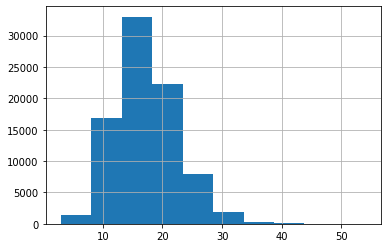

In [ ]:
# 데이터 길이 살펴보기

train['document'].map(len).hist()

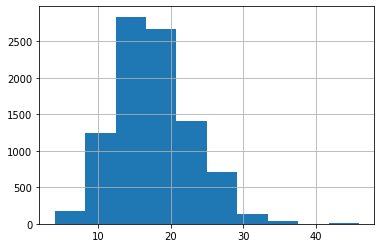

In [ ]:
dev['document'].map(len).hist()

2) 텍스트 정규화
- 띄어쓰기 정규화 (1. 띄어쓰기 2칸 -> 1칸으로 보정(train: 199개, dev: 11개) & 2. 띄어쓰기 오류 교정(train: 1356개, dev: 179개))

In [ ]:
#### 텍스트 정규화 (1) - soynlp 패키지의 emoticon_normalize 적용 (띄어쓰기 2칸인거 -> 1칸으로 변화)
!pip install soynlp

from soynlp.normalizer import *


# 모델 1 에 넣을 데이터
for docu1 in train['document']:
    docu1 = emoticon_normalize(docu1, num_repeats=3)

for docu2 in dev['document']:
    docu2 = emoticon_normalize(docu1, num_repeats=3)

# 모델 2 에 넣을 데이터
for docu1 in train_second['document']:
    docu1 = emoticon_normalize(docu1, num_repeats=3)

for docu2 in dev_second['document']:
    docu2 = emoticon_normalize(docu1, num_repeats=3)

     |████████████████████████████████| 419kB 21.6MB/s 


In [ ]:
# check

temp = train['document']
temp[100]

'앞 차 따라서 구미 나들목으로 진입.'

In [ ]:
#### 텍스트 정규화 (2) - soyspacing 패키지 CountSpace 적용 (띄어쓰기 오류 교정)
!pip install soyspacing

In [ ]:
from soyspacing.countbase import CountSpace

corpus_fname = args.data_dir + 'train.txt'
model_corpus = CountSpace()
model_corpus.train(corpus_fname) # train 데이터로 corpus를 학습합니다.

all tags length = 246728 --> 80648, (num_doc = 83711)

In [ ]:
model_fname = args.data_dir + 'corpus.txt'

model_corpus.save_model(model_fname, json_format=False) # 학습한 corpus가 파일로 생성됩니다.

In [ ]:
#another_model_fname = args.data_dir + 'corpus.txt'

#model = CountSpace()
#model.load_model(another_model_fname, json_format=False)

In [ ]:
verbose=False
mc = 10  # min_count
ft = 0.3 # force_abs_threshold
nt =-0.3 # nonspace_threshold
st = 0.3 # space_threshold

sent = '우리 단어 맞추는 해 보자.한글단어맞추기' # 예시

# with parameters
sent_corrected, tags = model_corpus.correct(
    doc=sent,
    verbose=verbose,
    force_abs_threshold=ft,
    nonspace_threshold=nt,
    space_threshold=st,
    min_count=mc)

# without parameters
sent_corrected, tags = model_corpus.correct(sent)

print(sent_corrected) # 예시

우리 단어 맞추는 해 보자.한글단어맞추기


In [ ]:
# train, dev 데이터에 적용

# 모델1 용
for docu1 in train['document']:    
    sent_corrected, tags = model_corpus.correct(docu1)
    docu1 = sent_corrected

for docu in dev['document']:    
    sent_corrected2, tags2 = model_corpus.correct(docu)
    docu = sent_corrected2



# 모델2 용
for docu1 in train_second['document']:    
    sent_corrected, tags = model_corpus.correct(docu1)
    docu1 = sent_corrected

for docu in dev_second['document']:    
    sent_corrected2, tags2 = model_corpus.correct(docu)
    docu = sent_corrected2

In [ ]:
train_second

,label,document
1200,5.차량제어-좌석제어-좌석온도내리기,슬슬 더우니 시트 온도 낮춰.
1201,5.차량제어-좌석제어-좌석온도내리기,시트 속도가 일도 낮았으면 좋겠어.
1202,5.차량제어-좌석제어-좌석온도내리기,앞 좌석 두 개 온도를 낮게 해.
1203,5.차량제어-좌석제어-좌석온도내리기,시트 온도 낮게 가.
1204,5.차량제어-좌석제어-좌석온도내리기,운전해 온도 한 단계 내려요?
...,...,...
83707,1.엔터테인먼트-음성게임-한글단어맞추기,우리 단어 맞추는 해 보자.
83708,1.엔터테인먼트-음성게임-한글단어맞추기,나 싶어 게임 완전 잘하는데 같이 하자.
83709,1.엔터테인먼트-음성게임-한글단어맞추기,단어 맞추기 함께.
83710,1.엔터테인먼트-음성게임-한글단어맞추기,단어 게임은 하실래요?


In [ ]:
dev_second

,label,document
141,5.차량제어-좌석제어-좌석온도내리기,더워서 좌석 온도 좀만 내려.
142,5.차량제어-좌석제어-좌석온도내리기,운전석 빼고 나머지 시트 전부 시원하게 만들어.
209,5.차량제어-창문제어-전체창문닫기,때 가 뒤에 전체 창문 닫아.
210,5.차량제어-창문제어-전체창문닫기,앞뒤 창문 다 올려.
211,5.차량제어-창문제어-전체창문닫기,비가 오니 전체 창문 올려.
...,...,...
9223,7.교육-놀이&운동서비스-주사위게임안내,주사 게임 하는 방법 보여줄래?
9224,5.안심케어-메시지-가족에게자동전화,소리 지르면 바람 엄마한테 전화 걸어.
9225,1.엔터테인먼트-감성대화-축하하기,우리 반 고장 됐어.
9226,5.안심케어-메시지-긴급메시지취소,위험 문자 보내지 않아도 될 것 알아요.


In [ ]:
# check

temp = train['document']
temp[100]

'앞 차 따라서 구미 나들목으로 진입.'

In [ ]:
## 해당 bert 는 data_load() 과정에서 범주형 label_list를 처리해주기에 y_data(labels) 인코딩을 안 해주어도 됩니다.


#from sklearn.preprocessing import LabelEncoder

#LE = LabelEncoder()

#LE.fit(list(train['label'])+list(dev['label']))
#train['label'] = LE.transform(train['label'])
#dev['label'] = LE.transform(dev['label'])

In [ ]:
train

,label,document
0,1.차량제어-운전제어-일자따라가기,앞차 뒤에서 똑같이 가.
1,1.차량제어-운전제어-일자따라가기,앞차 뒤에서 따라가 달려.
2,1.차량제어-운전제어-일자따라가기,앞차보다 먼저 가지 말고 따라가.
3,1.차량제어-운전제어-일자따라가기,앞차랑 안전거리 유지하고 운행해.
4,1.차량제어-운전제어-일자따라가기,앞에 차랑 목적지가 좁으니까 따라서 가.
...,...,...
83707,others,우리 단어 맞추는 해 보자.
83708,others,나 싶어 게임 완전 잘하는데 같이 하자.
83709,others,단어 맞추기 함께.
83710,others,단어 게임은 하실래요?


# 임시 파일들 저장

In [ ]:
# 모델 입력 파일 형식에 맞게 column 순서 바꾸어 파일 저장 - 모델1

train = train[['document', 'label']]
train.to_csv(args.data_dir + 'train2_first.txt', sep = '\t', encoding="utf-8")

dev = dev[['document', 'label']]
dev.to_csv(args.data_dir + 'dev2_first.txt', sep = '\t', encoding="utf-8")

In [ ]:
train

,document,label
0,앞차 뒤에서 똑같이 가.,1.차량제어-운전제어-일자따라가기
1,앞차 뒤에서 따라가 달려.,1.차량제어-운전제어-일자따라가기
2,앞차보다 먼저 가지 말고 따라가.,1.차량제어-운전제어-일자따라가기
3,앞차랑 안전거리 유지하고 운행해.,1.차량제어-운전제어-일자따라가기
4,앞에 차랑 목적지가 좁으니까 따라서 가.,1.차량제어-운전제어-일자따라가기
...,...,...
83707,우리 단어 맞추는 해 보자.,others
83708,나 싶어 게임 완전 잘하는데 같이 하자.,others
83709,단어 맞추기 함께.,others
83710,단어 게임은 하실래요?,others


In [ ]:
dev

,document,label
0,내 앞에 있는 차 계속 따라가.,1.차량제어-운전제어-일자따라가기
1,차 따라붙기 가능하냐?,1.차량제어-운전제어-일자따라가기
2,앞차와 제동거리를 유지하면서 따라가.,1.차량제어-운전제어-일자따라가기
3,앞차 따라 안 붙어?,1.차량제어-운전제어-일자따라가기
4,앞에 차 뒤에 붙어줄래?,1.차량제어-운전제어-일자따라가기
...,...,...
9223,주사 게임 하는 방법 보여줄래?,others
9224,소리 지르면 바람 엄마한테 전화 걸어.,others
9225,우리 반 고장 됐어.,others
9226,위험 문자 보내지 않아도 될 것 알아요.,others


In [ ]:
# 모델 입력 파일 형식에 맞게 column 순서 바꾸어 파일 저장 - 모델2

train_second = train_second[['document', 'label']]
train_second.to_csv(args.data_dir + 'train2_second.txt', sep = '\t', encoding="utf-8")

dev_second = dev_second[['document', 'label']]
dev_second.to_csv(args.data_dir + 'dev2_second.txt', sep = '\t', encoding="utf-8")

In [ ]:
train_second

,document,label
1200,슬슬 더우니 시트 온도 낮춰.,5.차량제어-좌석제어-좌석온도내리기
1201,시트 속도가 일도 낮았으면 좋겠어.,5.차량제어-좌석제어-좌석온도내리기
1202,앞 좌석 두 개 온도를 낮게 해.,5.차량제어-좌석제어-좌석온도내리기
1203,시트 온도 낮게 가.,5.차량제어-좌석제어-좌석온도내리기
1204,운전해 온도 한 단계 내려요?,5.차량제어-좌석제어-좌석온도내리기
...,...,...
83707,우리 단어 맞추는 해 보자.,1.엔터테인먼트-음성게임-한글단어맞추기
83708,나 싶어 게임 완전 잘하는데 같이 하자.,1.엔터테인먼트-음성게임-한글단어맞추기
83709,단어 맞추기 함께.,1.엔터테인먼트-음성게임-한글단어맞추기
83710,단어 게임은 하실래요?,1.엔터테인먼트-음성게임-한글단어맞추기


In [ ]:
dev_second

,document,label
141,더워서 좌석 온도 좀만 내려.,5.차량제어-좌석제어-좌석온도내리기
142,운전석 빼고 나머지 시트 전부 시원하게 만들어.,5.차량제어-좌석제어-좌석온도내리기
209,때 가 뒤에 전체 창문 닫아.,5.차량제어-창문제어-전체창문닫기
210,앞뒤 창문 다 올려.,5.차량제어-창문제어-전체창문닫기
211,비가 오니 전체 창문 올려.,5.차량제어-창문제어-전체창문닫기
...,...,...
9223,주사 게임 하는 방법 보여줄래?,7.교육-놀이&운동서비스-주사위게임안내
9224,소리 지르면 바람 엄마한테 전화 걸어.,5.안심케어-메시지-가족에게자동전화
9225,우리 반 고장 됐어.,1.엔터테인먼트-감성대화-축하하기
9226,위험 문자 보내지 않아도 될 것 알아요.,5.안심케어-메시지-긴급메시지취소


# 모델 학습 시작

# ☆★☆★☆ 첫번째 모델 ☆★☆★☆

In [ ]:
##### Training 코드 짜는 법 #####

###  첫번째 모델 1.선언 2.training 3.저장 ###
# model = ☆★☆★☆
# model.fit(padded_first_tr, label_first_tr, validation_data = [padded_first_dev, label_first_dev], ☆★☆★☆)
# model.save(☆★☆my_first_model☆★☆)

###  두번째 모델 1.선언 2.training 3.저장 ###
# model = ☆★☆★☆
# model.fit(padded_second_tr, label_second_tr, validation_data = [padded_second_dev, label_second_dev], ☆★☆★☆)
# model.save(☆★☆my_first_model☆★☆)


##### prediction 코드 짜는 법 #####

### 1. 첫번째 모델 불러옴 2.inference 실행 3.
# model = load(☆★☆★☆)
# prediction = model.predict(☆★☆ test_data ☆★☆)

##Model Load


In [ ]:
# 해당 모델에서 쓰일 label_list 설정해주기
label_list = (train['label']).unique() # 변경

config = AutoConfig.from_pretrained(
    args.model_name_or_path,
    num_labels= 302, ## 변경 !!
    id2label={str(i): label for i, label in enumerate(label_list)},
    label2id={label: i for i, label in enumerate(label_list)},
    )
tokenizer = AutoTokenizer.from_pretrained(
    args.model_name_or_path, 
    do_lower_case=args.do_lower_case
    )
model = AutoModelForSequenceClassification.from_pretrained(
    args.model_name_or_path,
    config=config
    )
model.to(args.device)
print("Finish")


Some weights of the model checkpoint at jason9693/soongsil-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jason9693/soongsil-roberta-base and are newly initialized: ['classifier.dense.weight', 'classif

Finish


## 모델 1 Tokenizing

#NSMC Data Load (모델1)

학습을 위해서 Text File을 `Dataset`형태로 변환하는 부분입니다.

이 과정은 간단하게 3단계로 나뉘어집니다.
1. Text File로부터 Text 읽어오기
2. Text, Label로 분리하기
3. Tokenizer로 text를 학습에 사용할 수 있는 형태로 바꿈

In [ ]:
def load_data(tokenizer, mode):
  
  print(f"Creating features from dataset file at '{args.data_dir}'")
  
  # 1. Read file
  file_to_read = None
  if mode == "train_first":
    file_to_read = args.train_first_file
  elif mode == "train_second":
    file_to_read = args.train_second_file

  elif mode == "dev_first":
    file_to_read = args.dev_first_file
  elif mode == "dev_second":
    file_to_read = args.dev_second_file


  
  input_path = os.path.join(args.data_dir, args.task, file_to_read)
  print(f"LOOKING AT {input_path}")
  with open(input_path, "r", encoding="utf-8") as f:
    lines = []
    for line in f:
      #print(line.strip()))
      lines.append(line.strip())


  # 2. Split line to data
  texts = []
  label_map = {label: i for i, label in enumerate(label_list)} # 변경
  labels = []
  for (i, line) in enumerate(lines[1:]): #[1:]
    line = line.split("\t")
    if len(line) != 3:
      print(f"Error {line}")
      continue
    text_a = line[1]
    if text_a == "":
      continue    
    if i % 10000 ==0:
      print(f"[{i}] {line}")

    # Text Data
    texts.append({
        "text_a": text_a
    })
    # Label
    labels.append(label_map[line[2]])
    

  # 3. Convert text data to feature
  batch_encoding = tokenizer.batch_encode_plus(
      [(text["text_a"]) for text in texts],
      max_length=args.max_seq_len,
      padding="max_length",
      add_special_tokens=True,
      truncation=True,
  )

  features = []
  for i in range(len(texts)):
    input = {k: batch_encoding[k][i] for k in  batch_encoding}
    if "token_type_ids" not in input:
      input["token_type_ids"] = [0] * len(input["input_ids"])
    features.append(input)

  for i, feature in enumerate(features[:5]):
    print("*** Example ***")
    print("input_ids: {}".format(" ".join([str(x) for x in feature["input_ids"]])))
    print("attention_mask: {}".format(" ".join([str(x) for x in feature["attention_mask"]])))
    print("token_type_ids: {}".format(" ".join([str(x) for x in feature["token_type_ids"]])))
    print("label: {}".format(labels[i]))

  # Convert feature to dataset
  all_input_ids = torch.tensor([f["input_ids"] for f in features], dtype=torch.long)
  all_attention_mask = torch.tensor([f["attention_mask"] for f in features], dtype=torch.long)
  all_token_type_ids = torch.tensor([f["token_type_ids"] for f in features], dtype=torch.long)
  all_labels = torch.tensor(labels, dtype=torch.long)

  dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
  return dataset


`train_dataset`은 train용 데이터셋

`dev_dataset`은 validation용 데이터셋

`test_dataset`은 evaluate용 데이터셋


In [ ]:
# Ex) load_data(tokenizer, "모드 이름(train/dev/test)")

train_dataset_first = load_data(tokenizer, "train_first") 

Creating features from dataset file at '/content/drive/MyDrive/intention/'
LOOKING AT /content/drive/MyDrive/intention/train2_first.txt
[0] ['0', '앞차 뒤에서 똑같이 가.', '1.차량제어-운전제어-일자따라가기']
[10000] ['10002', '테이블과 스탠드가 비치된 상영 좀 소개해.', '2.영화관-시설안내-시설세부정보']
[20000] ['20002', '어디서 택시가 서냐?', 'others']
[30000] ['30002', '왼쪽 차선으로 끼어들기 해서 운전해.', '2.차선제어-차선변경-왼쪽으로차선변경']
[40000] ['40004', '분야별로 인기 많은 책 알고 있어.', '3.도서관-도서검색/대출-카테고리검색']
[50000] ['50004', '내가 집에 갔으니 외출 모드를 꺼요 수 있겠어?', 'others']
[60000] ['60004', '컴퓨터 플러그 내 방에 꽂혀 있어?', '3.플러그-컴퓨터플러그-위치']
[70000] ['70006', '여기 식당에 메뉴는 뭐가 있지?', 'others']
[80000] ['80006', '저 대신 사진을 철수한테 보내요.', '1.어린이집-사진,캠-전송']
*** Example ***
input_ids: 0 2250 743 8743 4495 398 18 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
attention_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
label: 0
*** Example ***
input_ids: 0 2250 743 8743 1912 287 

In [ ]:
dev_dataset_first = load_data(tokenizer, "dev_first")

Creating features from dataset file at '/content/drive/MyDrive/intention/'
LOOKING AT /content/drive/MyDrive/intention/dev2_first.txt
[0] ['0', '내 앞에 있는 차 계속 따라가.', '1.차량제어-운전제어-일자따라가기']
*** Example ***
input_ids: 0 746 3871 625 882 1282 1912 287 18 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
attention_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
label: 0
*** Example ***
input_ids: 0 743 1000 573 6992 317 1379 1831 35 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
attention_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
label: 0
*** Example ***
input_ids: 0 2250 743 523 542 604 11385 3792 1549 1912 287 18 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
model.classifier()

# Finetuning

특정 Dataset의 accuracy를 확인하는 코드

In [ ]:
# evalute() 함수 정의

def evaluate(_model, _eval_dataset, mode, _global_step=None):
  results = {}
  eval_sampler = SequentialSampler(_eval_dataset)
  eval_dataloader = DataLoader(_eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

  # Eval!
  if _global_step != None:
    print(f"***** Running evaluation on {mode} dataset ({_global_step} step) *****")
  else:
    print(f"***** Running evaluation on {mode} dataset *****")
  print(f"  Num examples = {len(_eval_dataset)}")
  print(f"  Eval Batch size = {args.eval_batch_size}")
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None

  # Dataloader [for]
  for batch in progress_bar(eval_dataloader):
    _model.eval()
    batch = tuple(t.to(args.device) for t in batch)

    with torch.no_grad():
      inputs = {
          "input_ids": batch[0], # 'id'
          "attention_mask": batch[1], # 'document'
          "labels": batch[3] # class 'labels'
      }
      if args.model_type not in ["distilkobert", "xlm-roberta"]:
        inputs["token_type_ids"] = batch[2]  # Distilkobert, XLM-Roberta don't use segment_ids
      outputs = _model(**inputs)
      tmp_eval_loss, logits = outputs[:2]

      eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if preds is None:
      preds = logits.detach().cpu().numpy()
      out_label_ids = inputs["labels"].detach().cpu().numpy()
    else:
      preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
      out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)
  # End Dataloader [for]

  eval_loss = eval_loss / nb_eval_steps
  preds = np.argmax(preds, axis=1)
  result = {
      "acc": (out_label_ids == preds).mean(),
      #"tmp_eval_loss": tmp_eval_loss,
      "지금까지 average_eval_loss": eval_loss
  }
  results.update(result)

  output_dir_first = os.path.join(args.output_dir_first, mode)
  if not os.path.exists(output_dir_first):
    os.makedirs(output_dir_first)

  output_eval_file = os.path.join(output_dir_first, f"{mode}-{_global_step}.txt" if _global_step else f"{mode}.txt")
  with open(output_eval_file, "w") as f_w:
    print(f"***** Eval results on {mode} dataset *****")
    for key in sorted(results.keys()):
      print(f"  {key} = {str(results[key])}")
      f_w.write(f"  {key} = {str(results[key])}\n")

  return results

In [ ]:
train_sampler = RandomSampler(train_dataset_first)
train_dataloader = DataLoader(train_dataset_first, sampler=train_sampler, batch_size=args.train_batch_size)

NameError: ignored

In [ ]:
if args.max_steps > 0:
  t_total = args.max_steps
  args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
else:
  t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs  

NameError: ignored

In [ ]:
global_step = 1
epochs_trained = 0
steps_trained_in_current_epoch = 0

if os.path.exists(args.output_dir_first):
  try:
    print("  Find latest checkpoint")
    ckpts_suffix = [int(c.split("-")[-1]) for c in os.listdir(args.output_dir_first) if c.startswith("checkpoint")] 
    global_step = max(ckpts_suffix)
    ckpt_path = os.path.join(args.output_dir_first, f"checkpoint-{global_step}" )
    
    model = AutoModelForSequenceClassification.from_pretrained(ckpt_path)
    model.to(args.device)

    epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
    steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)
    print("  Continuing training from checkpoint, will skip to saved global_step")
    print(f"  Continuing training from epoch {epochs_trained}")
    print(f"  Continuing training from global step {global_step}", )
    print(f"  Will skip the first {steps_trained_in_current_epoch} steps in the first epoch")
  except ValueError:
    print("  Starting fine-tuning.")

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
  {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
   'weight_decay': args.weight_decay},
  {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
   'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * args.warmup_proportion), num_training_steps=t_total)

##Training

In [ ]:
# 현경 수정
# Train!
print("***** Running training *****")
print(f"  Traning model_ = {args.model_name_or_path}")
print(f"  Num examples = {len(train_dataset_first)}")
print(f"  Num Epochs = {args.num_train_epochs}")
print(f"  Total train batch size = {args.train_batch_size}")
print(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
print(f"  Total optimization steps = {t_total}")
print(f"  Logging steps = {args.logging_steps}")
print(f"  Save steps = { args.save_steps}")

tr_loss = 0.0
model.zero_grad()
mb = master_bar(range(int(args.num_train_epochs)))
for epoch in mb:
  if epochs_trained > 0:
    epochs_trained -= 1
    continue

  epoch_iterator = progress_bar(train_dataloader, parent=mb)
  # One epoch train
  for step, batch in enumerate(epoch_iterator):
    # Skip past any already trained steps if resuming training
    if steps_trained_in_current_epoch > 0:
      steps_trained_in_current_epoch -= 1
      continue

    model.train()
    batch = tuple(t.to(args.device) for t in batch)
    inputs = {
        "input_ids":batch[0],
        "attention_mask": batch[1],
        "labels": batch[3]
    }

    if args.model_type not in ["distilkobert", "xlm-roberta"]:
      inputs["token_type_ids"] = batch[2]  # Distilkobert, XLM-Roberta don't use segment_ids
    outputs = model(**inputs)

    loss = outputs[0]

    if args.gradient_accumulation_steps > 1:
      loss = loss / args.gradient_accumulation_steps

    loss.backward()
    tr_loss += loss.item()
    # Accumulation 
    if (step + 1) % args.gradient_accumulation_steps == 0 or (
        len(train_dataloader) <= args.gradient_accumulation_steps 
        and (step + 1) == len(train_dataloader)
    ):
      torch.nn.utils.clip_grad_norm(model.parameters(), args.max_grad_norm)

      optimizer.step()
      scheduler.step()
      model.zero_grad()
      global_step += 1




      # Evaluate 
      if args.logging_steps > 0 and global_step % args.logging_steps == 0:
        if args.evaluate_test_during_training:
          evaluate(model, dev_dataset_first, mode="dev_first", _global_step=global_step) # 모델 1
        
        else:
          evaluate(model, test_dataset, mode="test", _global_step=global_step)
      # End Evaluate [if]

      # Save model checkpoint
      if args.save_steps > 0 and global_step % args.save_steps == 0:
        output_dir_first = os.path.join(args.output_dir_first, f"checkpoint-{global_step}")
        if not os.path.exists(output_dir_first):
          os.makedirs(output_dir_first)
        model_to_save = model.module if hasattr(model, "module") else model
        model_to_save.save_pretrained(output_dir_first)

        torch.save(args, os.path.join(output_dir_first, "training_args.bin"))
        print(f" Saving model checkpoint to {output_dir_first}")

        if args.save_optimizer:
          torch.save(optimizer.state_dict(), os.path.join(output_dir_first, "optimizer.pt"))
          torch.save(scheduler.state_dict(), os.path.join(output_dir_first, "scheduler.pt"))
      # End Save model [if]
    # End Accumulation [if]
    
    if args.max_steps > 0 and global_step > args.max_steps:
      break
  # End One epoch train [for]
  mb.write("Epoch {} done".format(epoch + 1))

  if args.max_steps > 0 and global_step > args.max_steps:
    break 
tr_loss = tr_loss / global_step # 평균 train_loss 출력


***** Running training *****
  Traning model_ = jason9693/soongsil-roberta-base
  Num examples = 83706
  Num Epochs = 10
  Total train batch size = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 26160
  Logging steps = 2000
  Save steps = 2000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


***** Running evaluation on dev_first dataset (2000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.49588209796272215
  지금까지 average_eval_loss = 2.545202866400758
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-2000
***** Running evaluation on dev_first dataset (4000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.6251625487646294
  지금까지 average_eval_loss = 1.6717627044409922
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-4000
***** Running evaluation on dev_first dataset (6000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.6786952752492414
  지금까지 average_eval_loss = 1.2984233882329235
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-6000
***** Running evaluation on dev_first dataset (8000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.716514954486346
  지금까지 average_eval_loss = 1.1245700561836973
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-8000
***** Running evaluation on dev_first dataset (10000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.7363459037711313
  지금까지 average_eval_loss = 1.0400397344811323
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-10000
***** Running evaluation on dev_first dataset (12000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.7418725617685306
  지금까지 average_eval_loss = 1.0462734676795462
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-12000
***** Running evaluation on dev_first dataset (14000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.7549848287819679
  지금까지 average_eval_loss = 1.0468845498071957
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-14000
***** Running evaluation on dev_first dataset (16000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.7544429995665366
  지금까지 average_eval_loss = 1.059822777362719
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-16000
***** Running evaluation on dev_first dataset (18000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.7575856090160381
  지금까지 average_eval_loss = 1.0548493078310195
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-18000
***** Running evaluation on dev_first dataset (20000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.7572605114867794
  지금까지 average_eval_loss = 1.089633776308739
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-20000
***** Running evaluation on dev_first dataset (22000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.7605114867793672
  지금까지 average_eval_loss = 1.0856292737673408
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-22000
***** Running evaluation on dev_first dataset (24000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.7600780234070221
  지금까지 average_eval_loss = 1.093675236179404
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-24000
***** Running evaluation on dev_first dataset (26000 step) *****
  Num examples = 9228
  Eval Batch size = 128


***** Eval results on dev_first dataset *****
  acc = 0.7606198526224534
  지금까지 average_eval_loss = 1.0952509947835583
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-26000


In [ ]:
print(f"global_step = {global_step}, average loss = {tr_loss}")

global_step = 26161, average loss = 0.852969992514259


- test 예측 (inference)

In [ ]:
#### 모델 1 훈련 결과로 Inference Prediction 하는 코드






# ☆★☆★☆ 두번째 모델 ☆★☆★☆

##Model Load (모델2 용)


In [ ]:
# 해당 모델에서 쓰일 label_list 설정해주기
label_list_second = (train_second['label']).unique() # train 데이터만 학습에 사용하므로


config = AutoConfig.from_pretrained(
    args.model_name_or_path,
    num_labels_second= len(class_del_list), ## 변경 !!
    id2label={str(i): label for i, label in enumerate(label_list_second)},
    label2id={label: i for i, label in enumerate(label_list_second)},
    )
tokenizer = AutoTokenizer.from_pretrained(
    args.model_name_or_path, 
    do_lower_case=args.do_lower_case
    )
model = AutoModelForSequenceClassification.from_pretrained(
    args.model_name_or_path,
    config=config
    )
model.to(args.device)
print("Finish")


Some weights of the model checkpoint at jason9693/soongsil-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jason9693/soongsil-roberta-base and are newly initialized: ['classifier.dense.weight', 'classif

Finish


## 모델 2 Tokenizing

In [ ]:
def load_data_second(tokenizer, mode):
  
  print(f"Creating features from dataset file at '{args.data_dir}'")
  
  # 1. Read file
  file_to_read = None
  if mode == "train_first":
    file_to_read = args.train_first_file
  elif mode == "train_second":
    file_to_read = args.train_second_file


  elif mode == "dev_first":
    file_to_read = args.dev_first_file
  elif mode == "dev_second":
    file_to_read = args.dev_second_file


  
  input_path = os.path.join(args.data_dir, args.task, file_to_read)
  print(f"LOOKING AT {input_path}")
  with open(input_path, "r", encoding="utf-8") as f:
    lines = []
    for line in f:
      #print(line.strip()))
      lines.append(line.strip())


  # 2. Split line to data
  texts = []
  label_map = {label: i for i, label in enumerate(label_list_second)}
  labels = []
  for (i, line) in enumerate(lines[1:]): #[1:]
    line = line.split("\t")
    if len(line) != 3:
      print(f"Error {line}")
      continue
    text_a = line[1]
    if text_a == "":
      continue    
    if i % 10000 ==0:
      print(f"[{i}] {line}")

    # Text Data
    texts.append({
        "text_a": text_a
    })
    # Label
    labels.append(label_map[line[2]])
    

  # 3. Convert text data to feature
  batch_encoding = tokenizer.batch_encode_plus(
      [(text["text_a"]) for text in texts],
      max_length=args.max_seq_len,
      padding="max_length",
      add_special_tokens=True,
      truncation=True,
  )

  features = []
  for i in range(len(texts)):
    input = {k: batch_encoding[k][i] for k in  batch_encoding}
    if "token_type_ids" not in input:
      input["token_type_ids"] = [0] * len(input["input_ids"])
    features.append(input)

  for i, feature in enumerate(features[:5]):
    print("*** Example ***")
    print("input_ids: {}".format(" ".join([str(x) for x in feature["input_ids"]])))
    print("attention_mask: {}".format(" ".join([str(x) for x in feature["attention_mask"]])))
    print("token_type_ids: {}".format(" ".join([str(x) for x in feature["token_type_ids"]])))
    print("label: {}".format(labels[i]))

  # Convert feature to dataset
  all_input_ids = torch.tensor([f["input_ids"] for f in features], dtype=torch.long)
  all_attention_mask = torch.tensor([f["attention_mask"] for f in features], dtype=torch.long)
  all_token_type_ids = torch.tensor([f["token_type_ids"] for f in features], dtype=torch.long)
  all_labels = torch.tensor(labels, dtype=torch.long)

  dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
  return dataset


`train_dataset`은 train용 데이터셋

`dev_dataset`은 validation용 데이터셋

`test_dataset`은 evaluate용 데이터셋


In [ ]:
# Ex) load_data(tokenizer, "모드 이름(train/dev/test)")

train_dataset_second = load_data_second(tokenizer, "train_second") 

Creating features from dataset file at '/content/drive/MyDrive/intention/'
LOOKING AT /content/drive/MyDrive/intention/train2_second.txt
[0] ['1200', '슬슬 더우니 시트 온도 낮춰.', '5.차량제어-좌석제어-좌석온도내리기']
[10000] ['31515', '멀리 컴퓨터만 전원 켤게.', '3.플러그-컴퓨터플러그-전원켜기']
[20000] ['60763', '히터 온도 이십 도로 맞는.', '2.공조제어-차량히터-온도조절']
*** Example ***
input_ids: 0 3065 3065 582 9828 487 634 1479 312 2568 2852 18 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
label: 0
*** Example ***
input_ids: 0 357 634 1256 2904 6355 2568 8300 13069 18 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
attention_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
label: 0
*** Example ***
input_ids: 0 2250 1299 898 895 610 1479 3431 2568 321 580 

In [ ]:
dev_dataset_second = load_data_second(tokenizer, "dev_second")

Creating features from dataset file at '/content/drive/MyDrive/intention/'
LOOKING AT /content/drive/MyDrive/intention/dev2_second.txt
[0] ['141', '더워서 좌석 온도 좀만 내려.', '5.차량제어-좌석제어-좌석온도내리기']
*** Example ***
input_ids: 0 642 2263 1299 898 1479 312 612 379 2194 18 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
label: 0
*** Example ***
input_ids: 0 6723 898 4299 6564 487 634 2472 11211 2014 18 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
label: 0
*** Example ***
input_ids: 0 840 398 4186 3638 2376 514 5585 319 18 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
attention_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# Finetuning

특정 Dataset의 accuracy를 확인하는 코드

In [ ]:
# evalute() 함수 정의

def evaluate(_model, _eval_dataset, mode, _global_step=None):
  results = {}
  eval_sampler = SequentialSampler(_eval_dataset)
  eval_dataloader = DataLoader(_eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

  # Eval!
  if _global_step != None:
    print(f"***** Running evaluation on {mode} dataset ({_global_step} step) *****")
  else:
    print(f"***** Running evaluation on {mode} dataset *****")
  print(f"  Num examples = {len(_eval_dataset)}")
  print(f"  Eval Batch size = {args.eval_batch_size}")
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None

  # Dataloader [for]
  for batch in progress_bar(eval_dataloader):
    _model.eval()
    batch = tuple(t.to(args.device) for t in batch)

    with torch.no_grad():
      inputs = {
          "input_ids": batch[0], # 'id'
          "attention_mask": batch[1], # 'document'
          "labels": batch[3] # class 'labels'
      }
      if args.model_type not in ["distilkobert", "xlm-roberta"]:
        inputs["token_type_ids"] = batch[2]  # Distilkobert, XLM-Roberta don't use segment_ids
      outputs = _model(**inputs)
      tmp_eval_loss, logits = outputs[:2]

      eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if preds is None:
      preds = logits.detach().cpu().numpy()
      out_label_ids = inputs["labels"].detach().cpu().numpy()
    else:
      preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
      out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)
  # End Dataloader [for]

  eval_loss = eval_loss / nb_eval_steps
  preds = np.argmax(preds, axis=1)
  result = {
      "acc": (out_label_ids == preds).mean(),
      #"tmp_eval_loss": tmp_eval_loss,
      "지금까지 average_eval_loss": eval_loss
  }
  results.update(result)

  output_dir_second = os.path.join(args.output_dir_second, mode)
  if not os.path.exists(output_dir_second):
    os.makedirs(output_dir_second)

  output_eval_file = os.path.join(output_dir_second, f"{mode}-{_global_step}.txt" if _global_step else f"{mode}.txt")
  with open(output_eval_file, "w") as f_w:
    print(f"***** Eval results on {mode} dataset *****")
    for key in sorted(results.keys()):
      print(f"  {key} = {str(results[key])}")
      f_w.write(f"  {key} = {str(results[key])}\n")

  return results

In [ ]:
train_sampler = RandomSampler(train_dataset_second)
train_dataloader = DataLoader(train_dataset_second, sampler=train_sampler, batch_size=args.train_batch_size)

In [ ]:
if args.max_steps > 0:
  t_total = args.max_steps
  args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
else:
  t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs  

In [ ]:
global_step = 1
epochs_trained = 0
steps_trained_in_current_epoch = 0

if os.path.exists(args.output_dir_second):
  try:
    print("  Find latest checkpoint")
    ckpts_suffix = [int(c.split("-")[-1]) for c in os.listdir(args.output_dir_second) if c.startswith("checkpoint")] 
    global_step = max(ckpts_suffix)
    ckpt_path = os.path.join(args.output_dir_second, f"checkpoint-{global_step}" )
    
    model = AutoModelForSequenceClassification.from_pretrained(ckpt_path)
    model.to(args.device)

    epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
    steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)
    print("  Continuing training from checkpoint, will skip to saved global_step")
    print(f"  Continuing training from epoch {epochs_trained}")
    print(f"  Continuing training from global step {global_step}", )
    print(f"  Will skip the first {steps_trained_in_current_epoch} steps in the first epoch")
  except ValueError:
    print("  Starting fine-tuning.")

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
  {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
   'weight_decay': args.weight_decay},
  {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
   'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * args.warmup_proportion), num_training_steps=t_total)

##Training

In [ ]:
# 현경 수정
# Train!
print("***** Running training *****")
print(f"  Traning model_ = {args.model_name_or_path}")
print(f"  Num examples = {len(train_dataset_second)}")
print(f"  Num Epochs = {args.num_train_epochs}")
print(f"  Total train batch size = {args.train_batch_size}")
print(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
print(f"  Total optimization steps = {t_total}")
print(f"  Logging steps = {args.logging_steps}")
print(f"  Save steps = { args.save_steps}")

tr_loss = 0.0
model.zero_grad()
mb = master_bar(range(int(args.num_train_epochs)))
for epoch in mb:
  if epochs_trained > 0:
    epochs_trained -= 1
    continue

  epoch_iterator = progress_bar(train_dataloader, parent=mb)
  # One epoch train
  for step, batch in enumerate(epoch_iterator):
    # Skip past any already trained steps if resuming training
    if steps_trained_in_current_epoch > 0:
      steps_trained_in_current_epoch -= 1
      continue

    model.train()
    batch = tuple(t.to(args.device) for t in batch)
    inputs = {
        "input_ids":batch[0],
        "attention_mask": batch[1],
        "labels": batch[3]
    }

    if args.model_type not in ["distilkobert", "xlm-roberta"]:
      inputs["token_type_ids"] = batch[2]  # Distilkobert, XLM-Roberta don't use segment_ids
    outputs = model(**inputs)

    loss = outputs[0]

    if args.gradient_accumulation_steps > 1:
      loss = loss / args.gradient_accumulation_steps

    loss.backward()
    tr_loss += loss.item()
    # Accumulation 
    if (step + 1) % args.gradient_accumulation_steps == 0 or (
        len(train_dataloader) <= args.gradient_accumulation_steps 
        and (step + 1) == len(train_dataloader)
    ):
      torch.nn.utils.clip_grad_norm(model.parameters(), args.max_grad_norm)

      optimizer.step()
      scheduler.step()
      model.zero_grad()
      global_step += 1

      # Evaluate 
      if args.logging_steps > 0 and global_step % args.logging_steps == 0:
        if args.evaluate_test_during_training:
          evaluate(model, dev_dataset_second, mode="dev_second", _global_step=global_step)
        else:
          evaluate(model, test_dataset, mode="test", _global_step=global_step)
      # End Evaluate [if]

      # Save model checkpoint
      if args.save_steps > 0 and global_step % args.save_steps == 0:
        output_dir_second = os.path.join(args.output_dir_second, f"checkpoint-{global_step}")
        if not os.path.exists(output_dir_second):
          os.makedirs(output_dir_second)
        model_to_save = model.module if hasattr(model, "module") else model
        model_to_save.save_pretrained(output_dir_second)

        torch.save(args, os.path.join(output_dir_second, "training_args.bin"))
        print(f" Saving model checkpoint to {output_dir_second}")

        if args.save_optimizer:
          torch.save(optimizer.state_dict(), os.path.join(output_dir_second, "optimizer.pt"))
          torch.save(scheduler.state_dict(), os.path.join(output_dir_second, "scheduler.pt"))
      # End Save model [if]
    # End Accumulation [if]
    
    if args.max_steps > 0 and global_step > args.max_steps:
      break
  # End One epoch train [for]
  mb.write("Epoch {} done".format(epoch + 1))

  if args.max_steps > 0 and global_step > args.max_steps:
    break 
tr_loss = tr_loss / global_step # 평균 train_loss 출력


***** Running training *****
  Traning model_ = jason9693/soongsil-roberta-base
  Num examples = 27867
  Num Epochs = 10
  Total train batch size = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8710
  Logging steps = 2000
  Save steps = 2000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


***** Running evaluation on dev_second dataset (2000 step) *****
  Num examples = 2763
  Eval Batch size = 128


***** Eval results on dev_second dataset *****
  acc = 0.666304741223308
  지금까지 average_eval_loss = 1.3746851899407126
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptsecond_model/checkpoint-2000
***** Running evaluation on dev_second dataset (4000 step) *****
  Num examples = 2763
  Eval Batch size = 128


***** Eval results on dev_second dataset *****
  acc = 0.7158885269634455
  지금까지 average_eval_loss = 1.168307450684634
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptsecond_model/checkpoint-4000
***** Running evaluation on dev_second dataset (6000 step) *****
  Num examples = 2763
  Eval Batch size = 128


***** Eval results on dev_second dataset *****
  acc = 0.7198697068403909
  지금까지 average_eval_loss = 1.1287279508330605
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptsecond_model/checkpoint-6000
***** Running evaluation on dev_second dataset (8000 step) *****
  Num examples = 2763
  Eval Batch size = 128


***** Eval results on dev_second dataset *****
  acc = 0.7180600796235975
  지금까지 average_eval_loss = 1.1162964512001385
 Saving model checkpoint to /content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptsecond_model/checkpoint-8000


In [ ]:
print(f"global_step = {global_step}, average loss = {tr_loss}")

global_step = 8711, average loss = 0.6697498015557334


- test 데이터 예측 (inference)

In [ ]:
#### 모델 2 훈련 결과로 Inference Prediction 하는 코드






#Evaluate (Inference)
(학습 시 저장한) 각 checkpoint에서의 모델의 성능을 확인함



- 평가할 text.txt 데이터 경로 설정

In [ ]:
input_text = args.data_dir +"test.txt"

In [ ]:
## 데이터 불러오기
test = pd.read_csv(input_text, header=None, names=['document'])

In [ ]:
test

,document
0,내 앞에 있는 차 계속 따라가.
1,차 따라붙기 가능하냐?
2,앞차와 제동거리를 유지하면서 따라가 줘.
3,앞차 따라 안 붙어?
4,앞에 차 뒤에 붙어줄래?
5,나의 앞차를 따라 가 주렴.


- test 데이터에 동일한 전처리 과정 적용

In [ ]:
# 혹시 있을 수 있는 결측값 제거
test = test.dropna()


# 전처리 똑같이 적용
test_data_text = list(test['document'])

test_clear_text = []


for i in range(len(test_data_text)):
  test_clear_text.append(test_data_text[i].replace(' 줘', '').replace(' 줄래', '').replace(' 주세요', ''))
test['document'] = test_clear_text



## 텍스트 정규화 (1) - soynlp 패키지의 emoticon_normalize 적용 (띄어쓰기 2칸인거 -> 1칸으로 변화)
for docu1 in test['document']:
    docu1 = emoticon_normalize(docu1, num_repeats=3)



## 텍스트 정규화 (2) - soyspacing 패키지 CountSpace 적용 (띄어쓰기 오류 교정)
for docu1 in test['document']:    
    sent_corrected, tags = model_corpus.correct(docu1)
    docu1 = sent_corrected



test

,document
0,내 앞에 있는 차 계속 따라가.
1,차 따라붙기 가능하냐?
2,앞차와 제동거리를 유지하면서 따라가.
3,앞차 따라 안 붙어?
4,앞에 차 뒤에 붙어줄래?
5,나의 앞차를 따라 가 주렴.


## test 데이터 Tokenizing

In [ ]:
def load_data_test(tokenizer, mode):
  
  print(f"Creating features from dataset file at '{args.data_dir}'")
  
  # 1. Read file
  file_to_read = None
  
  if mode == "test":
    file_to_read = args.test_file


  
  input_path = os.path.join(args.data_dir, args.task, file_to_read)
  print(f"LOOKING AT {input_path}")
  with open(input_path, "r", encoding="utf-8") as f:
    lines = []
    for line in f:
      #print(line.strip()))
      lines.append(line.strip())


  # 2. Split line to data
  texts = []
  #label_map = {label: i for i, label in enumerate(test['document'])}
  #labels = []

  for (i, line) in enumerate(lines[1:]): #[1:]
    line = line.split("\t")
    #if len(line) != 3:
      #print(f"Error {line}")
      #continue
    text_a = line[0]
    if text_a == "":
      continue    
    if i % 10000 ==0:
      print(f"[{i}] {line}")

    # Text Data
    texts.append({
        "text_a": text_a
    })
    # Label
    #labels.append(label_map[line[0]]) ##
    

  # 3. Convert text data to feature
  batch_encoding = tokenizer.batch_encode_plus(
      [(text["text_a"]) for text in texts],
      max_length=args.max_seq_len,
      padding="max_length",
      add_special_tokens=True,
      truncation=True,
  )

  features = []
  for i in range(len(texts)):
    input = {k: batch_encoding[k][i] for k in  batch_encoding}
    if "token_type_ids" not in input:
      input["token_type_ids"] = [0] * len(input["input_ids"])
    features.append(input)

  for i, feature in enumerate(features[:5]):
    print("*** Example ***")
    print("input_ids: {}".format(" ".join([str(x) for x in feature["input_ids"]])))
    print("attention_mask: {}".format(" ".join([str(x) for x in feature["attention_mask"]])))
    print("token_type_ids: {}".format(" ".join([str(x) for x in feature["token_type_ids"]])))
    #print("label: {}".format(labels[i]))

  # Convert feature to dataset
  all_input_ids = torch.tensor([f["input_ids"] for f in features], dtype=torch.long)
  all_attention_mask = torch.tensor([f["attention_mask"] for f in features], dtype=torch.long)
  all_token_type_ids = torch.tensor([f["token_type_ids"] for f in features], dtype=torch.long)
  #all_labels = torch.tensor(labels, dtype=torch.long)

  #dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
  dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids)
  return dataset


In [ ]:
def load_data_test(tokenizer, mode):
  
  print(f"Creating features from dataset file at '{args.data_dir}'")
  
  # 1. Read file
  file_to_read = None
  
  if mode == "test":
    file_to_read = args.test_file


  
  input_path = os.path.join(args.data_dir, args.task, file_to_read)
  print(f"LOOKING AT {input_path}")
  with open(input_path, "r", encoding="utf-8") as f:
    lines = []
    for line in f:
      #print(line.strip()))
      lines.append(line.strip())


  # 2. Split line to data
  texts = []
  label_map = {label: i for i, label in enumerate(test['document'])}
  labels = []

  for (i, line) in enumerate(lines[1:]): #[1:]
    line = line.split("\t")
    #if len(line) != 3:
      #print(f"Error {line}")
      #continue
    text_a = line[0]
    if text_a == "":
      continue    
    if i % 10000 ==0:
      print(f"[{i}] {line}")

    # Text Data
    texts.append({
        "text_a": text_a
    })
    # Label
    labels.append(label_map[line[0]]) ##
    

  # 3. Convert text data to feature
  batch_encoding = tokenizer.batch_encode_plus(
      [(text["text_a"]) for text in texts],
      max_length=args.max_seq_len,
      padding="max_length",
      add_special_tokens=True,
      truncation=True,
  )

  features = []
  for i in range(len(texts)):
    input = {k: batch_encoding[k][i] for k in  batch_encoding}
    if "token_type_ids" not in input:
      input["token_type_ids"] = [0] * len(input["input_ids"])
    features.append(input)

  for i, feature in enumerate(features[:5]):
    print("*** Example ***")
    print("input_ids: {}".format(" ".join([str(x) for x in feature["input_ids"]])))
    print("attention_mask: {}".format(" ".join([str(x) for x in feature["attention_mask"]])))
    print("token_type_ids: {}".format(" ".join([str(x) for x in feature["token_type_ids"]])))
    #print("label: {}".format(labels[i]))

  # Convert feature to dataset
  all_input_ids = torch.tensor([f["input_ids"] for f in features], dtype=torch.long)
  all_attention_mask = torch.tensor([f["attention_mask"] for f in features], dtype=torch.long)
  all_token_type_ids = torch.tensor([f["token_type_ids"] for f in features], dtype=torch.long)
  #all_labels = torch.tensor(labels, dtype=torch.long)

  #dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
  dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids)
  return dataset


In [ ]:
# data load 및 토큰화
test_dataset = load_data_test(tokenizer, "test")

Creating features from dataset file at '/content/drive/MyDrive/intention/'
LOOKING AT /content/drive/MyDrive/intention/test.txt
[0] ['차 따라붙기 가능하냐?']
*** Example ***
input_ids: 0 743 1000 573 6992 317 1379 1831 35 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
attention_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
*** Example ***
input_ids: 0 2250 743 523 542 604 11385 3792 1549 1912 287 3046 18 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
*** Example ***
input_ids: 0 2250 743 1912 477 7080 35 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
attention_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# Predict

In [ ]:
## 모델1

checkpoints_first = list(
      os.path.dirname(c) for c in sorted(glob.glob(args.output_dir_first + "/**/" + "pytorch_model.bin", recursive=True))
)

In [ ]:
checkpoints_first

['/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-10000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-12000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-14000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-16000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-18000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-2000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-20000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-22000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-24000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-26000',
 '/content/drive/MyDrive/intent

In [ ]:
#### 모델 1로 prediction 실행




In [ ]:
## 모델2

checkpoints_first = list(
      os.path.dirname(c) for c in sorted(glob.glob(args.output_dir_second + "/**/" + "pytorch_model.bin", recursive=True))
)

In [ ]:
checkpoints_second

['/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-10000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-12000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-14000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-16000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-18000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-2000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-20000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-22000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-24000',
 '/content/drive/MyDrive/intention/soongsil-roberta-base-nsmc-ckptfirst_model/checkpoint-26000',
 '/content/drive/MyDrive/intent

In [ ]:
#### 모델 2로 prediction 실행


